# Image Classification with Convolutional Neural Networks

In [56]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.functional import accuracy, f1_score, precision, recall
import logging
logging.getLogger('torchvision').setLevel(logging.WARNING)


## 1 - Load and Pre-process Data

- The CIFAR datasets consist of 32x32 color images, spliting them into training and testing sets. 
- Normalizing the images and convert the labels to one-hot encoded vectors.

In [96]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        ])

    def prepare_data(self):
        # Download CIFAR-10 dataset
        CIFAR10(root="data", train=True, download=True)
        CIFAR10(root="data", train=False, download=True)

    def setup(self, stage=None):
        # Split dataset into train and validation sets
        if stage == 'fit' or stage is None:
            cifar_full = CIFAR10(root="data", train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        if stage == 'test' or stage is None:
            self.cifar_test = CIFAR10(root="data", train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=self.batch_size)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5654321].


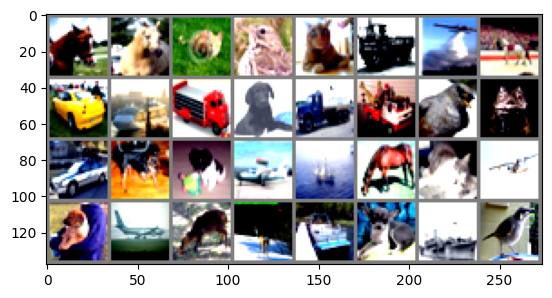

horse horse   cat  bird   cat truck plane horse   car  ship truck   dog truck truck  bird  frog   car   dog   dog plane  ship horse   cat plane   dog plane  deer  deer  ship   dog  ship  bird


In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and plot image 
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(data_module.train_dataloader())
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:32]))

# Print labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))


## 2 - Define the CNN Architecture

Also considering aspects like the depth of the network, and the balance between model complexity and the risk of overfitting.

## Architecture 1: Moderate Depth with Dropout
- Three convolutional layers with increasing number of filters (32, 64, 128) and kernel size of 3x3 with padding of 1
- Max pooling layers after each convolutional layer with pool size of 2x2
- Flatten layer to convert the feature maps into a 1D vector
- Two fully connected layers with 512 and 10 units respectively
- Dropout layer with a probability of 0.5 after the first fully connected layer

In [68]:
class CIFAR10Classifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

        self.train_losses = []
        self.val_losses = []
        


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels, task="multiclass", num_classes=10)
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        self.train_losses.append(loss)
        return loss
    
    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.train_losses).mean()
        print(f"Average training loss: {avg_loss.item()}")
        self.train_losses = [] 

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels, task="multiclass", num_classes=10)
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)
        self.val_losses.append(loss)
        
    def on_validation_epoch_end(self):
        avg_val_loss = torch.stack(self.val_losses).mean()
        self.log('avg_val_loss', avg_val_loss)
        self.val_losses = []

    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.train_losses).mean()
        print(f"Average training loss: {avg_loss.item()}")
        self.train_losses = []

    def test_step(self, batch, batch_idx):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels, task="multiclass", num_classes=10)
        f1 = f1_score(out, labels, num_classes=10, average='macro', task="multiclass")
        precision_value = precision(out, labels, num_classes=10, average='macro', task="multiclass")
        recall_value = recall(out, labels, num_classes=10, average='macro', task="multiclass")
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)
        self.log('test_f1', f1)
        self.log('test_precision', precision_value)
        self.log('test_recall', recall_value)
        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        

        return optimizer
    

## Training

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my_model',
    filename='Arch1-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)

data_module = CIFAR10DataModule()
model = CIFAR10Classifier()
trainer = Trainer(max_epochs=2, callbacks=[checkpoint_callback], logger=False)
trainer.fit(model, datamodule=data_module)

#validation dataset
trainer.validate(datamodule=data_module)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name    | Type      | Params
--------------------------------------
0 | conv1   | Conv2d    | 896   
1 | conv2   | Conv2d    | 18.5 K
2 | conv3   | Conv2d    | 73.9 K
3 | pool    | MaxPool2d | 0     
4 | fc1     | Linear    | 1.0 M 
5 | fc2     | Linear    | 5.1 K 
6 | dropout | Dropout   | 0     
--------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.590     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1407/1407 [00:14<00:00, 98.60it/s]               
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1407/1407 [00:14<00:00, 95.34it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1407/1407 [00:15<00:00, 89.15it/s]               Average training loss: 0.9802219271659851


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1407/1407 [00:15<00:00, 88.89it/s]


/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/mle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model/Arch1-epoch=01-val_loss=0.89.ckpt
Loaded model weights from the checkpoint at /Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model/Arch1-epoch=01-val_loss=0.89.ckpt


Validation DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 167.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      avg_val_loss          0.8903610706329346
      val_accuracy          0.6826000213623047
        val_loss            0.8916330933570862
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.8916330933570862,
  'val_accuracy': 0.6826000213623047,
  'avg_val_loss': 0.8903610706329346}]

## Architecture 2: Simplicity and Efficiency

- Two convolutional layers with 32 and 64 filters respectively and kernel size of 3x3 with padding of 1
- Max pooling layer after the second convolutional layer with pool size of 2x2
- Flatten layer to convert the feature maps into a 1D vector
- Two fully connected layers with 256 and 10 units respectively
- Dropout layer with a probability of 0.5 after the first fully connected layer

In [71]:
class CIFAR10Classifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Corrected dimensions here
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

        self.train_losses = []

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 64 * 8 * 8)  # Correct reshaping
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        self.train_losses.append(loss)
        return loss
    
    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.train_losses).mean()
        print(f"Average training loss: {avg_loss.item()}")
        self.train_losses = [] 

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels, task="multiclass", num_classes=10)
        f1 = f1_score(out, labels, num_classes=10, average='macro', task="multiclass")
        precision_value = precision(out, labels, num_classes=10, average='macro', task="multiclass")
        recall_value = recall(out, labels, num_classes=10, average='macro', task="multiclass")
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        self.log('val_f1', f1)
        self.log('val_precision', precision_value)
        self.log('val_recall', recall_value)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels, task="multiclass", num_classes=10)
        f1 = f1_score(out, labels, num_classes=10, average='macro', task="multiclass")
        precision_value = precision(out, labels, num_classes=10, average='macro', task="multiclass")
        recall_value = recall(out, labels, num_classes=10, average='macro', task="multiclass")
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        self.log('test_f1', f1)
        self.log('test_precision', precision_value)
        self.log('test_recall', recall_value)
        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        

        return optimizer
    
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my_model',
    filename='arc2-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)

data_module = CIFAR10DataModule()
model = CIFAR10Classifier()
trainer = Trainer(max_epochs=4, callbacks=[checkpoint_callback])
trainer.fit(model, datamodule=data_module)

#validation dataset
trainer.validate(datamodule=data_module)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/mle/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model exists and is not empty.

  | Name    | Type      | Params
--------------------------------------
0 | conv1   | Conv2d    | 896   
1 | conv2   | Conv2d    | 18.5 K
2 | pool    | MaxPool2d | 0     
3 | fc1     | Linear    | 1.0 M 
4 | fc2     | Linear    | 2.6 K 
5 | dropout | Dropout   | 0     
--------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.283     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/mle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/mle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1407/1407 [00:11<00:00, 126.71it/s, v_num=46]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1407/1407 [00:11<00:00, 127.71it/s, v_num=46]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1407/1407 [00:11<00:00, 122.98it/s, v_num=46]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1407/1407 [00:11<00:00, 117.87it/s, v_num=46]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1407/1407 [00:14<00:00, 100.34it/s, v_num=46]   Average training loss: 0.8396239876747131


`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1407/1407 [00:14<00:00, 99.93it/s, v_num=46] 


/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/mle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model/arc2-epoch=03-val_loss=0.81.ckpt
Loaded model weights from the checkpoint at /Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model/arc2-epoch=03-val_loss=0.81.ckpt


Validation DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 87.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7067999839782715
         val_f1             0.6577073931694031
        val_loss            0.8114708065986633
      val_precision         0.6838811635971069
       val_recall           0.6930679678916931
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.8114708065986633,
  'val_acc': 0.7067999839782715,
  'val_f1': 0.6577073931694031,
  'val_precision': 0.6838811635971069,
  'val_recall': 0.6930679678916931}]

# Architecture 3: Enhanced Feature Normalization

- Four convolutional layers with 32, 32, 64, and 64 filters respectively and kernel size of 3x3 with padding of 1
- Batch normalization layers after each convolutional layer
- Max pooling layers after the third and fourth convolutional layers with pool size of 2x2
- Flatten layer to convert the feature maps into a 1D vector
- Two fully connected layers with 256 and 10 units respectively
- Dropout layer with a probability of 0.5 after the first fully connected layer

In [73]:
class CIFAR10Classifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # First convolution layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization for the first conv layer
        
        # Second convolution layer
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization for the second conv layer
        
        # Third convolution layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # Batch Normalization for the third conv layer
        self.pool3 = nn.MaxPool2d(2, 2)  # Max Pooling layer
        
        # Fourth convolution layer
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)  # Batch Normalization for the fourth conv layer
        self.pool4 = nn.MaxPool2d(2, 2)  # Max Pooling layer
        
        # Fully connected layer
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Fully connected layer with input size matching the flattened output of the previous layer
        self.fc2 = nn.Linear(256, 10)  # Output layer for 10 classes (CIFAR-10)
        
        self.dropout = nn.Dropout(0.5)  # Dropout layer for regularization

        self.train_losses = []

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # First conv layer + BatchNorm + ReLU
        x = F.relu(self.bn2(self.conv2(x)))  # Second conv layer + BatchNorm + ReLU
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))  # Third conv layer + BatchNorm + ReLU + MaxPool
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))  # Fourth conv layer + BatchNorm + ReLU + MaxPool
        
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor to a vector for the fully connected layer
        
        x = F.relu(self.fc1(x))  # First fully connected layer + ReLU
        x = self.dropout(x)  # Dropout for regularization
        x = self.fc2(x)  # Final fully connected layer to produce class scores
        
        return x


    def training_step(self, batch, batch_idx):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        self.train_losses.append(loss)
        return loss
    
    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.train_losses).mean()
        print(f"Average training loss: {avg_loss.item()}")
        self.train_losses = [] 

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels, task="multiclass", num_classes=10)
        f1 = f1_score(out, labels, num_classes=10, average='macro', task="multiclass")
        precision_value = precision(out, labels, num_classes=10, average='macro', task="multiclass")
        recall_value = recall(out, labels, num_classes=10, average='macro', task="multiclass")
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        self.log('val_f1', f1)
        self.log('val_precision', precision_value)
        self.log('val_recall', recall_value)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels, task="multiclass", num_classes=10)
        f1 = f1_score(out, labels, num_classes=10, average='macro', task="multiclass")
        precision_value = precision(out, labels, num_classes=10, average='macro', task="multiclass")
        recall_value = recall(out, labels, num_classes=10, average='macro', task="multiclass")
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        self.log('test_f1', f1)
        self.log('test_precision', precision_value)
        self.log('test_recall', recall_value)
        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        

        return optimizer
    
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my_model',
    filename='arc3-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)

data_module = CIFAR10DataModule()
model = CIFAR10Classifier()
trainer = Trainer(max_epochs=10, callbacks=[checkpoint_callback])
trainer.fit(model, datamodule=data_module)

#validation dataset
trainer.validate(datamodule=data_module)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/mle/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model exists and is not empty.

   | Name    | Type        | Params
-----------------------------------------
0  | conv1   | Conv2d      | 896   
1  | bn1     | BatchNorm2d | 64    
2  | conv2   | Conv2d      | 9.2 K 
3  | bn2     | BatchNorm2d | 64    
4  | conv3   | Conv2d      | 18.5 K
5  | bn3     | BatchNorm2d | 128   
6  | pool3   | MaxPool2d   | 0     
7  | conv4   | Conv2d      | 36.9 K
8  | bn4     | BatchNorm2d | 128   
9  | pool4   | MaxPool2d   | 0     
10 | fc1     | Linear      | 1.0 M 
11 | fc2     | Linear      | 2.6 K 
12 | dropout | Dropout     | 0     
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.469     Tot

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/mle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/mle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1407/1407 [00:17<00:00, 81.71it/s, v_num=48]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1407/1407 [00:18<00:00, 77.75it/s, v_num=48]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1407/1407 [00:18<00:00, 76.45it/s, v_num=48]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1407/1407 [00:18<00:00, 75.95it/s, v_num=48]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1407/1407 [00:18<00:00, 75.14it/s, v_num=48]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 1407/1407 [00:18<00:00, 74.41it/s, v_num=48]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 1407/1407 [00:19<00:00, 73.29it/s, v_num=48]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 1407/1407 [00:19<00:00, 72.72it/s, v_num=48]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 1407/1407 [00:19<00:00, 71.46it/s, v_n

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1407/1407 [00:22<00:00, 62.01it/s, v_num=48]


/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/mle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model/arc3-epoch=09-val_loss=0.66.ckpt
Loaded model weights from the checkpoint at /Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model/arc3-epoch=09-val_loss=0.66.ckpt


Validation DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 73.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7767999768257141
         val_f1             0.7386966347694397
        val_loss            0.6560810208320618
      val_precision         0.7704790830612183
       val_recall           0.7606456279754639
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.6560810208320618,
  'val_acc': 0.7767999768257141,
  'val_f1': 0.7386966347694397,
  'val_precision': 0.7704790830612183,
  'val_recall': 0.7606456279754639}]

## Architecture 4: ResNet with BasicBlocks
- ResNet architecture with BasicBlock as the building block
- Three layers: layer1, layer2, and layer3 with increasing number of filters (16, 32, 64) and stride of 1, 2, 2 respectively
- Each layer consists of a specified number of BasicBlocks (2, 2, 2 in this case)
- BasicBlock contains two convolutional layers with batch normalization and ReLU activation
- Shortcut connection is added to the BasicBlock to enable residual learning
- Global average pooling is applied after the last layer
- Fully connected layer with 10 units for classification

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score, Precision, Recall
from pytorch_lightning.callbacks import ModelCheckpoint

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class CIFAR10Classifier(pl.LightningModule):
    def __init__(self, num_blocks=[2, 2, 2], num_classes=10):
        super(CIFAR10Classifier, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.train_losses = []
        self.val_losses = []

        self.accuracy = Accuracy(num_classes=num_classes, average='macro', task="multiclass")
        self.f1_score = F1Score(num_classes=num_classes, average='macro', task="multiclass")
        self.precision = Precision(num_classes=num_classes, average='macro', task="multiclass")
        self.recall = Recall(num_classes=num_classes, average='macro', task="multiclass")

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes * BasicBlock.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)  # Global Average Pooling
        out = out.view(out.size(0), -1)  # Flatten the output
        out = self.linear(out)
        return out

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        self.train_losses.append(loss)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(outputs, labels))
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(outputs, labels))
        self.log('test_f1', self.f1_score(outputs, labels))
        self.log('test_precision', self.precision(outputs, labels))
        self.log('test_recall', self.recall(outputs, labels))

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        self.val_losses.append(loss)
        self.log('val_loss', loss)
        self.log('val_acc', self.accuracy(outputs, labels))
        self.log('val_f1', self.f1_score(outputs, labels))
        self.log('val_precision', self.precision(outputs, labels))
        self.log('val_recall', self.recall(outputs, labels))

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
        return [optimizer], [scheduler]

# Setup a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my_model',
    filename='resnet-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min'
)
# Assume CIFAR10DataModule is defined elsewhere
data_module = CIFAR10DataModule()
model = CIFAR10Classifier()
trainer = Trainer(max_epochs=5, callbacks=[checkpoint_callback])
trainer.fit(model, datamodule=data_module)
trainer.validate(datamodule=data_module)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/mle/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model exists and is not empty.

  | Name      | Type                | Params
--------------------------------------------------
0 | conv1     | Conv2d              | 432   
1 | bn1       | BatchNorm2d         | 32    
2 | layer1    | Sequential          | 9.3 K 
3 | layer2    | Sequential          | 33.1 K
4 | layer3    | Sequential          | 131 K 
5 | linear    | Linear              | 650   
6 | accuracy  | MulticlassAccuracy  | 0     
7 | f1_score  | MulticlassF1Score   | 0     
8 | precision | MulticlassPrecision | 0     
9 | recall    | MulticlassRecall    | 0     
--------------------------------------------------
175 K     Trainable params
0         Non-trainable params
175 K     Total params
0.70

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/mle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/mle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1407/1407 [00:28<00:00, 50.10it/s, v_num=58]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1407/1407 [00:28<00:00, 48.87it/s, v_num=58]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1407/1407 [00:28<00:00, 49.66it/s, v_num=58]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1407/1407 [00:29<00:00, 47.53it/s, v_num=58]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1407/1407 [00:29<00:00, 47.15it/s, v_num=58]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1407/1407 [00:32<00:00, 42.96it/s, v_num=58]    

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1407/1407 [00:32<00:00, 42.91it/s, v_num=58]


/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/mle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model/resnet-epoch=04-val_loss=0.66.ckpt
Loaded model weights from the checkpoint at /Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model/resnet-epoch=04-val_loss=0.66.ckpt


Validation DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 57.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7647034525871277
         val_f1             0.7350460886955261
        val_loss            0.6614799499511719
      val_precision         0.7645420432090759
       val_recall           0.7647034525871277
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.6614799499511719,
  'val_acc': 0.7647034525871277,
  'val_f1': 0.7350460886955261,
  'val_precision': 0.7645420432090759,
  'val_recall': 0.7647034525871277}]

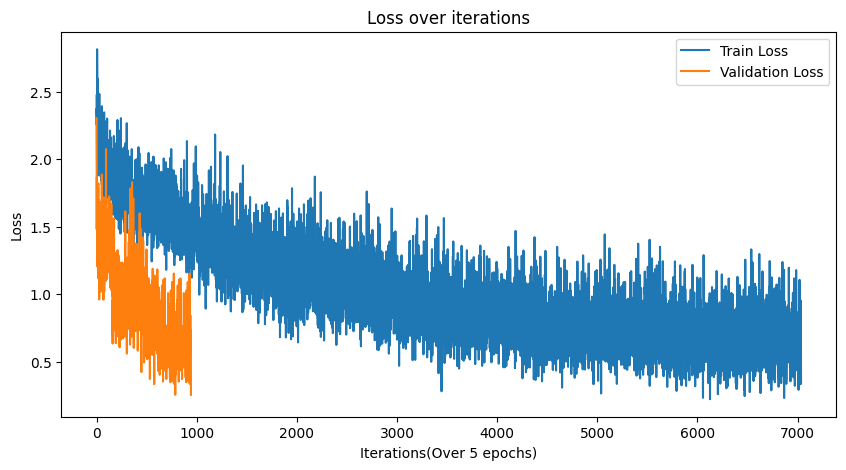

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot([loss.item() for loss in model.train_losses], label='Train Loss')
plt.plot([loss.item() for loss in model.val_losses], label='Validation Loss')
plt.title('Loss over iterations')
plt.xlabel('Iterations(Over 5 epochs)')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
# loading and further training the model

model_path = 'my_model/resnet-epoch=05-val_loss=0.55.ckpt'

restored_model = CIFAR10Classifier.load_from_checkpoint(model_path)

# Setup trainer with updated max_epochs
trainer = Trainer(max_epochs=50, callbacks=[checkpoint_callback])

# If you wish to continue training, use `current_epoch` to set the correct starting point
trainer.fit(restored_model, datamodule=data_module, ckpt_path=model_path)
trainer.validate(datamodule=data_module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at my_model/resnet-epoch=05-val_loss=0.55.ckpt

  | Name      | Type                | Params
--------------------------------------------------
0 | conv1     | Conv2d              | 432   
1 | bn1       | BatchNorm2d         | 32    
2 | layer1    | Sequential          | 9.3 K 
3 | layer2    | Sequential          | 33.1 K
4 | layer3    | Sequential          | 131 K 
5 | linear    | Linear              | 650   
6 | accuracy  | MulticlassAccuracy  | 0     
7 | f1_score  | MulticlassF1Score   | 0     
8 | precision | MulticlassPrecision | 0     
9 | recall    | MulticlassRecall    | 0     
--------------------------------------------------
175 K     Trainable params
0         Non-trainable params
175 K     Total params
0.701     Total estimated model params size (MB)
Restored all states from the checkpoint at my_model/resnet-epoch=05-val_loss=0.55.ckpt


Epoch 6: 100%|██████████| 1407/1407 [00:26<00:00, 52.37it/s, v_num=57]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 1407/1407 [00:27<00:00, 51.02it/s, v_num=57]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 1407/1407 [00:28<00:00, 49.37it/s, v_num=57]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 1407/1407 [00:29<00:00, 47.88it/s, v_num=57]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 1407/1407 [00:29<00:00, 47.11it/s, v_num=57]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 1407/1407 [00:32<00:00, 43.52it/s, v_num=57]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 1407/1407 [00:30<00:00, 45.69it/s, v_num=57]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 1407/1407 [00:30<00:00, 45.79it/s, v_num=57]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 1407

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1407/1407 [00:45<00:00, 30.68it/s, v_num=57]
Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model/resnet-epoch=12-val_loss=0.52.ckpt
Loaded model weights from the checkpoint at /Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model/resnet-epoch=12-val_loss=0.52.ckpt


Validation DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 58.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8080363869667053
         val_f1             0.7875672578811646
        val_loss            0.5208101272583008
      val_precision         0.8127965927124023
       val_recall           0.8080363869667053
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.5208101272583008,
  'val_acc': 0.8080363869667053,
  'val_f1': 0.7875672578811646,
  'val_precision': 0.8127965927124023,
  'val_recall': 0.8080363869667053}]

# 4 - Evaluate the Model

- Loading the best model and evaluating it on the test set.

In [94]:
# Load the model from the checkpoint

model = CIFAR10Classifier.load_from_checkpoint(checkpoint_path='/Users/krishan/Documents/GitHub/Image-Classification-with-Convolutional-Neural-Networks/my_model/resnet-epoch=12-val_loss=0.52.ckpt')

# Test the model
trainer.test(model, datamodule=data_module)

Files already downloaded and verified
Files already downloaded and verified
Testing DataLoader 0: 100%|██████████| 313/313 [00:05<00:00, 56.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.783514142036438
         test_f1             0.760894775390625
        test_loss           0.5851583480834961
     test_precision         0.7854191660881042
       test_recall           0.783514142036438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5851583480834961,
  'test_acc': 0.783514142036438,
  'test_f1': 0.760894775390625,
  'test_precision': 0.7854191660881042,
  'test_recall': 0.783514142036438}]

# Analysis of the all architectures, their training processes, and evaluation results


### ANN vs CNN vs ResNet

![RNN CNN](CNN.png)

![Resnet](ResNEt.png)


## Architecture 1: Moderate Depth with Dropout

### Chosen Architecture
- Three convolutional layers with increasing number of filters (32, 64, 128) and kernel size of 3x3 with padding of 1
- Max pooling layers after each convolutional layer with pool size of 2x2
- Flatten layer to convert the feature maps into a 1D vector
- Two fully connected layers with 512 and 10 units respectively
- Dropout layer with a probability of 0.5 after the first fully connected layer

### Rationale: 
This architecture is designed to balance complexity and computational efficiency. It gradually increases the number of filters, which helps in learning more complex features at deeper layers. The use of dropout helps to mitigate overfitting, making this architecture suitable for scenarios where moderate complexity is paired with a need for robustness against data variance.

### Evaluation Results
- Average training loss: 0.9802
- Validation loss: 0.8916
- Validation accuracy: 0.6826

## Architecture 2: Simplicity and Efficiency

### Chosen Architecture
- Two convolutional layers with 32 and 64 filters respectively and kernel size of 3x3 with padding of 1
- Max pooling layer after the second convolutional layer with pool size of 2x2
- Flatten layer to convert the feature maps into a 1D vector
- Two fully connected layers with 256 and 10 units respectively
- Dropout layer with a probability of 0.5 after the first fully connected layer

### Rationale: 
With only two convolutional layers followed by pooling, this architecture is the simplest and potentially the fastest to train among the presented options. It still incorporates dropout for overfitting control, making it efficient yet relatively robust.

### Evaluation Results
- Average training loss: 0.8396
- Validation loss: 0.8115
- Validation accuracy: 0.7068

## Architecture 3: Enhanced Feature Normalization

### Chosen Architecture
- Four convolutional layers with 32, 32, 64, and 64 filters respectively and kernel size of 3x3 with padding of 1
- Batch normalization layers after each convolutional layer
- Max pooling layers after the third and fourth convolutional layers with pool size of 2x2
- Flatten layer to convert the feature maps into a 1D vector
- Two fully connected layers with 256 and 10 units respectively
- Dropout layer with a probability of 0.5 after the first fully connected layer


### Rationale: 
The inclusion of batch normalization after each convolutional layer is aimed at stabilizing learning and improving convergence rates. This architecture is more complex than the first two but offers better handling of internal covariate shift, leading to potentially better and more stable performance.

### Evaluation Results
- Average training loss: 0.6413
- Validation loss: 0.6561
- Validation accuracy: 0.7768

## Architecture 4: ResNet with BasicBlocks

### Chosen Architecture
- ResNet architecture with BasicBlock as the building block
- Three layers: layer1, layer2, and layer3 with increasing number of filters (16, 32, 64) and stride of 1, 2, 2 respectively
- Each layer consists of a specified number of BasicBlocks (2, 2, 2 in this case)
- BasicBlock contains two convolutional layers with batch normalization and ReLU activation
- Shortcut connection is added to the BasicBlock to enable residual learning
- Global average pooling is applied after the last layer
- Fully connected layer with 10 units for classification

### Rationale: 
This architecture uses residual learning to allow for deeper networks without the degradation problem, typically associated with vanishing gradients in very deep networks. The use of BasicBlocks with shortcut connections helps in learning an identity function, ensuring that the added layers can only improve the training loss. The global average pooling reduces the total number of parameters, thus decreasing the risk of overfitting compared to using dense layers.

### Evaluation Results
- Validation loss: 0.5208
- Validation accuracy: 80.80%
- Validation F1 score: 0.7875
- Validation precision: 0.812
- Validation recall: 0.8080

## Comparison and Analysis

Based on the evaluation results, Architecture 4, which is the ResNet architecture with BasicBlocks, performs the best among the four architectures. It achieves the lowest validation loss of 0.5208 and the highest validation accuracy of 80.80%. Additionally, it provides good scores for F1, precision, and recall metrics.

The key differences in Architecture 4 compared to the other architectures are:
- Use of residual learning with shortcut connections in the BasicBlocks
- Deeper architecture with multiple layers and blocks
- Global average pooling instead of flatten and fully connected layers
- No explicit dropout layer

The ResNet architecture with BasicBlocks enables the model to learn residual functions and allows for deeper networks without suffering from the vanishing gradient problem. The shortcut connections facilitate the flow of information across layers.

Finally the model is evaluated on the test set and the results are as follows:
- Test loss: 0.5851
- Test accuracy: 78.35%
- Test F1 score: 0.7608
- Test precision: 0.7854
- Test recall: 0.7835

In conclusion, the ResNet architecture with BasicBlocks (Architecture 4) demonstrates the best performance among the four architectures for the CIFAR-10 dataset. The use of residual learning, deeper architecture, and global average pooling contributes to its superior performance in terms of validation loss, accuracy, and other evaluation metrics.

